<a href="https://colab.research.google.com/github/JamesPeralta/Machine-Learning-Algorithms/blob/master/IMBD%20Movie%20Review%20Classifier/LSTM%20Neural%20Network/IMDBUsingLSTM_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Creating an IMDB movie classifier using LSTM

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

### Retrieve and pre-process the data

In [2]:
max_features = 10000
maxlen = 500
batch_size = 128

print('Loading data...')
(input_train, y_train), (input_test, y_test) = tf.keras.datasets.imdb.load_data(
     num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = tf.keras.preprocessing.sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = tf.keras.preprocessing.sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


### Define model

In [9]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(max_features, 32, input_shape=(500,)))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


### Convert to TPU model

In [10]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)

INFO:tensorflow:Querying Tensorflow master (grpc://10.79.33.242:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 6042501780571282630)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 10764876584536515840)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 710012188866133070)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 13295142309574102666)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 3742340320300457418)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/

In [0]:
tpu_model.compile(
    optimizer=tf.train.RMSPropOptimizer(learning_rate=1e-3),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=['acc']
)

In [16]:
%%time
history = tpu_model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)


Train on 25000 samples, validate on 5000 samples
Epoch 1/10
24960/25000 [============================>.] - ETA: 0s - loss: 0.1234 - acc: 0.9567INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(16,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(16, 500), dtype=tf.float32, name='embedding_1_input_10'), TensorSpec(shape=(16, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for embedding_1_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.219799518585205 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(1,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(1, 500), dtype=tf.float32, name='embedding_1_input_10'), TensorSpec(shape=(1, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping pla

### Plot results

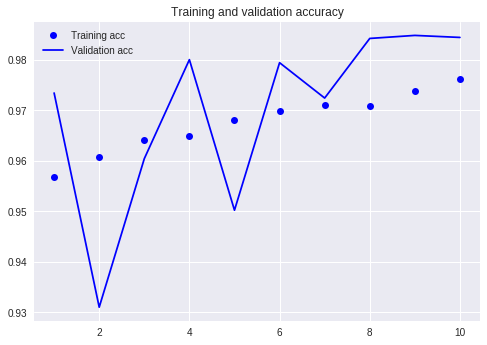

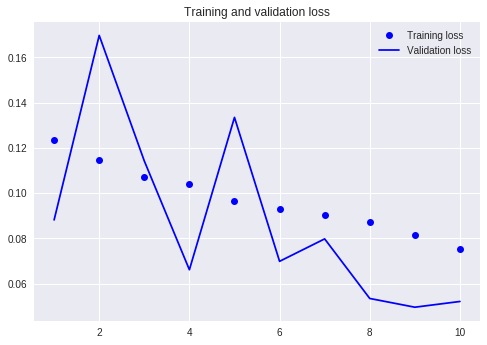

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()